# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

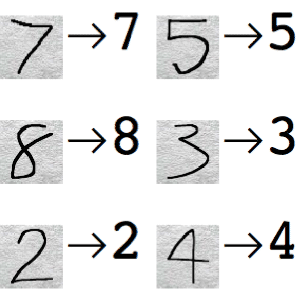

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


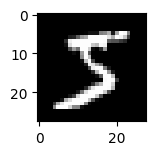

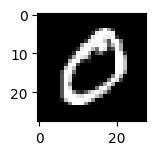

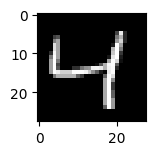

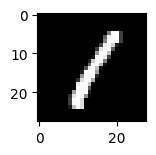

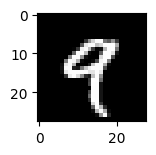

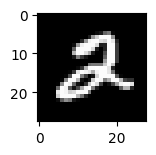

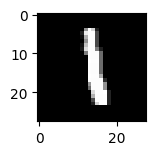

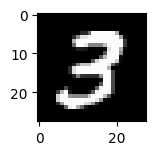

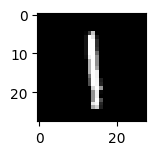

In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [2]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [3]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [4]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [5]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=256, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [7]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.142
> 98.083
> 97.892
> 98.167
> 97.950


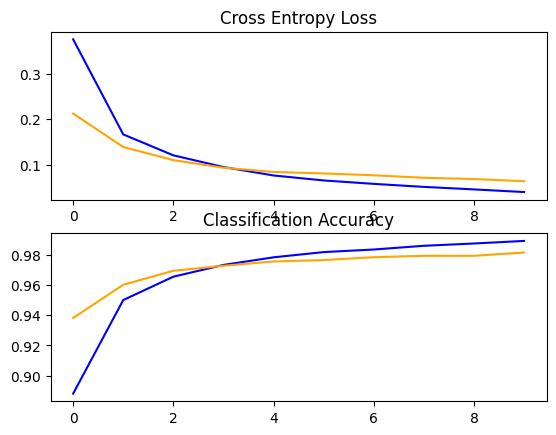

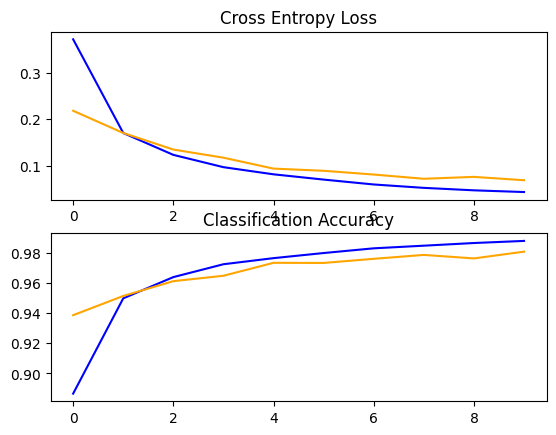

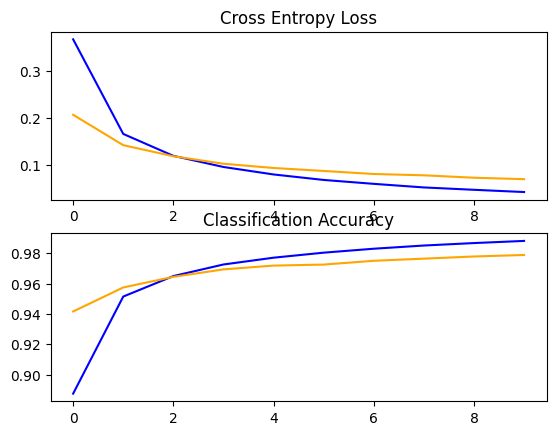

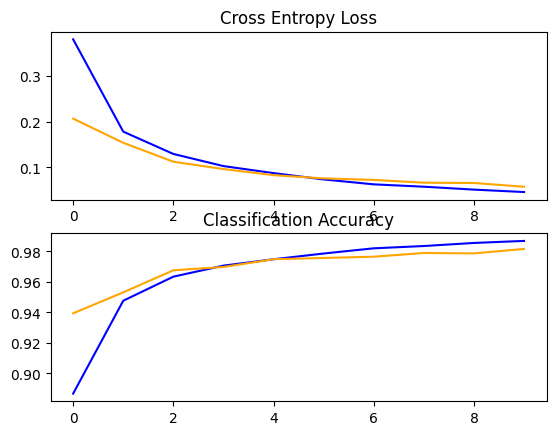

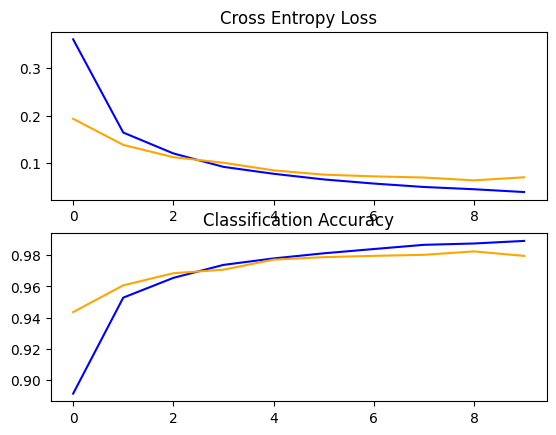

Accuracy: mean=98.047 std=0.108, n=5


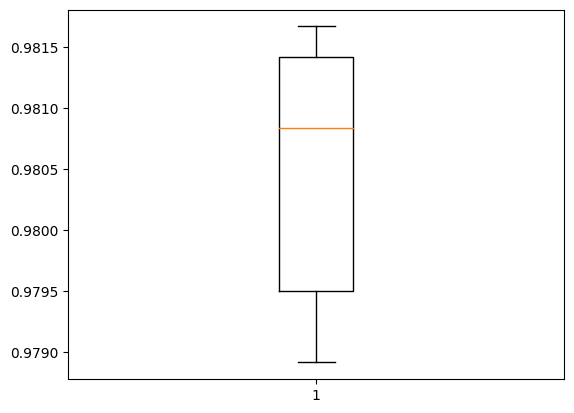

In [10]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [41]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=1)

  # save model
  model.save('final_model.h5')

[văn bản liên kết](https://)## Evaluate Final Model

In [42]:
run_test_harness2()

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1651 - accuracy: 0.9492
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0574 - accuracy: 0.9819
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0367 - accuracy: 0.9887
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0260 - accuracy: 0.9920
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0184 - accuracy: 0.9949
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0123 - accuracy: 0.9966
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0080 - accuracy: 0.9980
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0059 - accuracy: 0.9986
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.002

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [13]:
!gdown 1_44dfPdTqIWuPW3F_4IujWymgSLAoRKy

Downloading...
From: https://drive.google.com/uc?id=1_44dfPdTqIWuPW3F_4IujWymgSLAoRKy
To: /content/data.zip
100% 210k/210k [00:00<00:00, 127MB/s]


In [14]:
!unzip /content/data.zip -d /content/image

Archive:  /content/data.zip
   creating: /content/image/data/
   creating: /content/image/data/22521624/
   creating: /content/image/data/22521624/0/
  inflating: /content/image/data/22521624/0/0.jpeg  
  inflating: /content/image/data/22521624/0/0_2.jpeg  
  inflating: /content/image/data/22521624/0/0_3.jpeg  
   creating: /content/image/data/22521624/1/
  inflating: /content/image/data/22521624/1/1.jpeg  
  inflating: /content/image/data/22521624/1/1_2.jpeg  
  inflating: /content/image/data/22521624/1/1_3.jpeg  
   creating: /content/image/data/22521624/2/
  inflating: /content/image/data/22521624/2/2.jpeg  
  inflating: /content/image/data/22521624/2/2_2.jpeg  
  inflating: /content/image/data/22521624/2/2_3.jpeg  
   creating: /content/image/data/22521624/3/
  inflating: /content/image/data/22521624/3/3.jpeg  
  inflating: /content/image/data/22521624/3/3_2.jpeg  
  inflating: /content/image/data/22521624/3/3_3.jpeg  
   creating: /content/image/data/22521624/4/
  inflating: /cont

In [37]:
from pathlib import Path
import cv2

def zoom(img, zoom_factor=1.5):

    y_size = img.shape[0]
    x_size = img.shape[1]

    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor))
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))

    # first crop image then scale
    img_cropped = img[y1:y2,x1:x2]

    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)
def preprocessing():
  folder_list = Path("/content/image/data/22521624").glob("*")
  for fol in folder_list:
    img_list = Path(fol).glob("*.jpeg")
    for p in img_list:
      img = cv2.imread(str(p))
      img = zoom(img)
      img = 1- cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.fastNlMeansDenoising(img, None, 20, 7, 21)
      img = cv2.GaussianBlur(img, (9,9), 10)
      Path(str(p.parents[0]).replace("image","data")).mkdir(parents=True, exist_ok=True)
      cv2.imwrite(str(p).replace("image","data"),1-img)

preprocessing()

In [38]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))
  # convert to array
  img = img_to_array(img)
  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)
  # image = Image.fromarray(img)
  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return 1-img

In [39]:
# load an image and predict the class
from pathlib import Path
from tqdm import tqdm
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# img = mpimg.imread('your_image.png')
# imgplot = plt.imshow(img)
# plt.show()

def run_example():
  # load the image
  acc = 0
  img_list = Path("/content/data/data/22521624").glob("*/*.jpeg")
  total = len(list(Path("/content/data/data/22521624").glob("*/*.jpeg")))
  for img_path in tqdm(img_list):
    image = mpimg.imread(img_path)
    imgplot = plt.imshow(1-image)
    plt.show()
    # image.show()
    # image.save("/content/test.png")
    img = load_image(img_path)
    # img.save("test.png")

    # load model
    model = load_model('final_model.h5')

    # predict the class
    predict_value = model.predict(img)

    digit = argmax(predict_value)
    print(digit)
    if int(digit) == int(img_path.stem.split(" ")[0]):
      acc+=1
  print((1.*acc)/total)



0it [00:00, ?it/s]

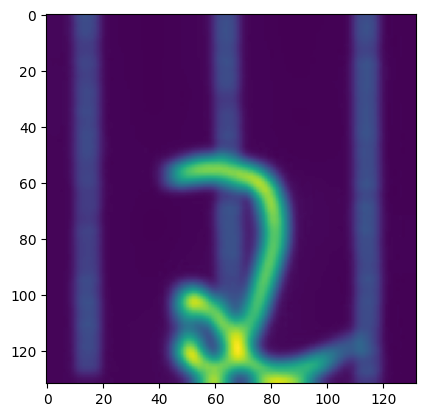

1/1 [==============================] - 0s 77ms/step


1it [00:00,  1.91it/s]

5


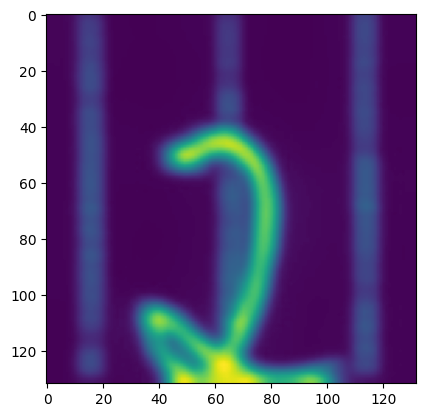

1/1 [==============================] - 0s 51ms/step


2it [00:01,  2.00it/s]

7


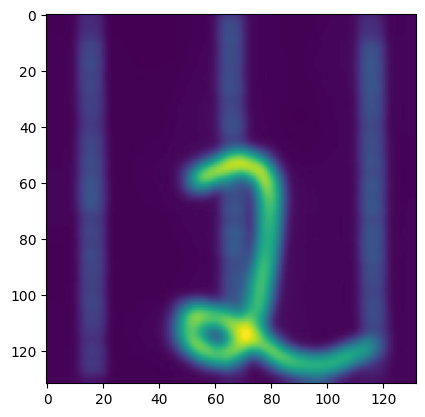

1/1 [==============================] - 0s 50ms/step


3it [00:01,  2.29it/s]

3


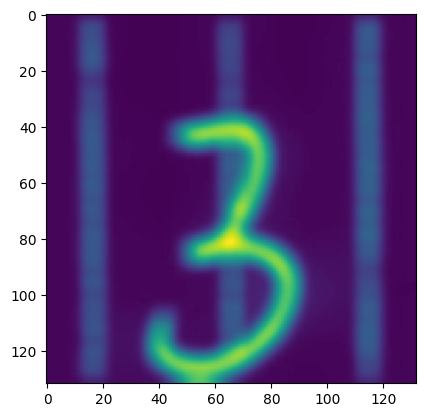

1/1 [==============================] - 0s 61ms/step


4it [00:01,  2.39it/s]

3


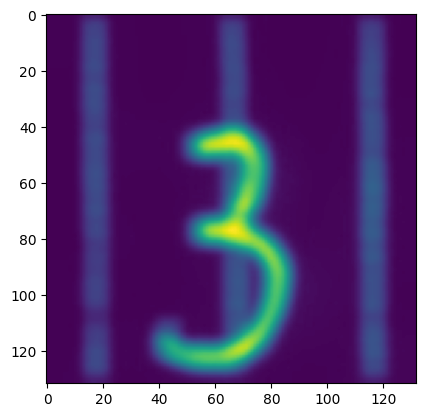

1/1 [==============================] - 0s 51ms/step


5it [00:02,  2.47it/s]

3


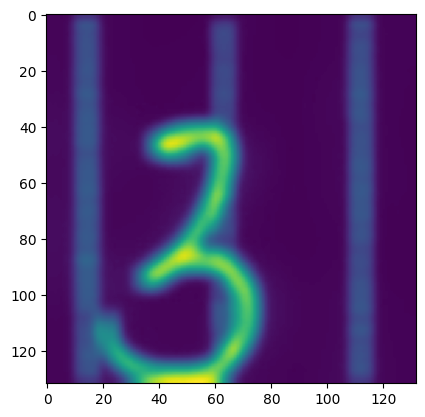

1/1 [==============================] - 0s 52ms/step


6it [00:02,  2.52it/s]

7


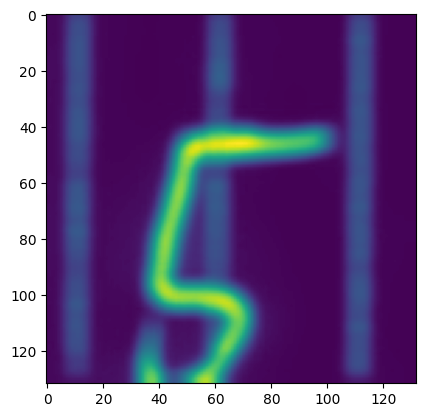

1/1 [==============================] - 0s 50ms/step


7it [00:02,  2.54it/s]

5


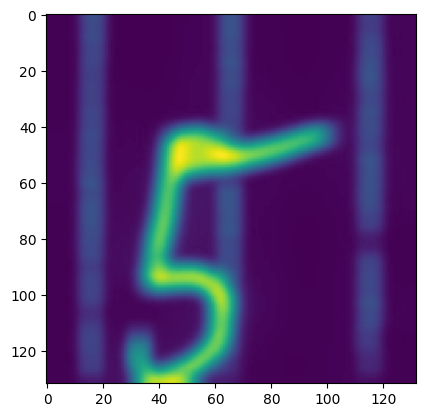

1/1 [==============================] - 0s 50ms/step


8it [00:03,  2.54it/s]

5


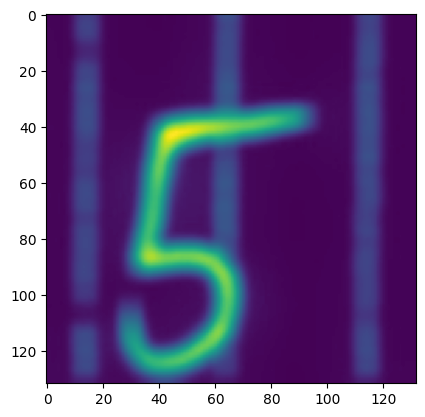

1/1 [==============================] - 0s 53ms/step


9it [00:03,  2.59it/s]

5


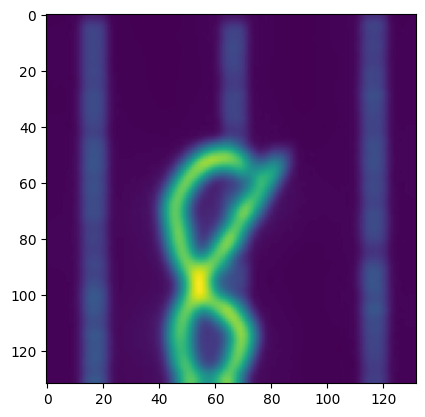

1/1 [==============================] - 0s 51ms/step


10it [00:04,  2.59it/s]

6


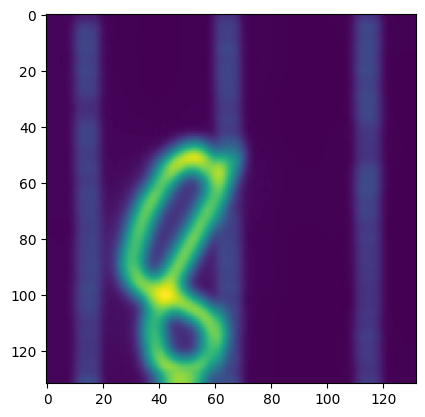

1/1 [==============================] - 0s 51ms/step


11it [00:04,  2.58it/s]

0


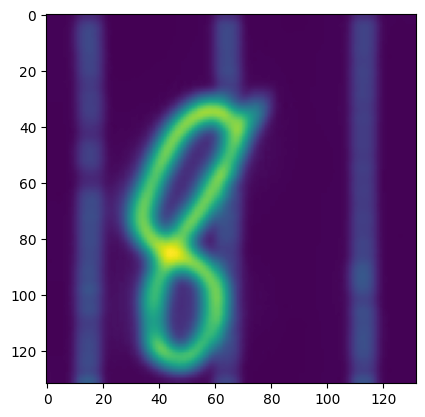

1/1 [==============================] - 0s 81ms/step


12it [00:04,  2.55it/s]

0


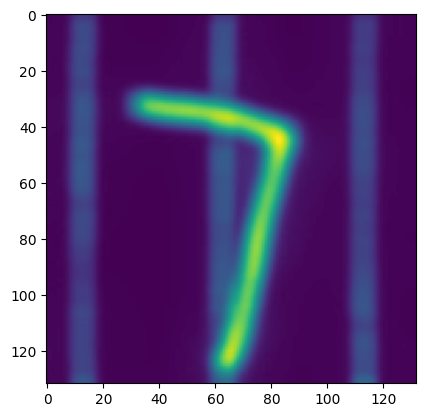

1/1 [==============================] - 0s 56ms/step


13it [00:05,  2.57it/s]

7


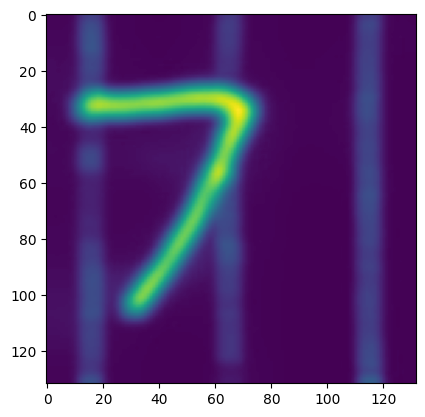

1/1 [==============================] - 0s 52ms/step


14it [00:05,  2.58it/s]

2


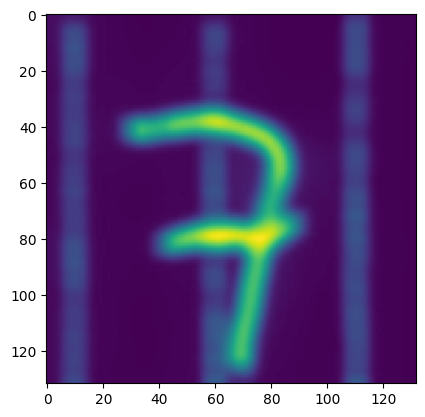

1/1 [==============================] - 0s 50ms/step


15it [00:06,  2.56it/s]

7


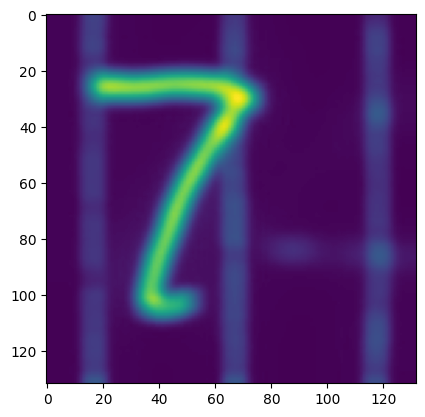

1/1 [==============================] - 0s 50ms/step


16it [00:06,  2.56it/s]

2


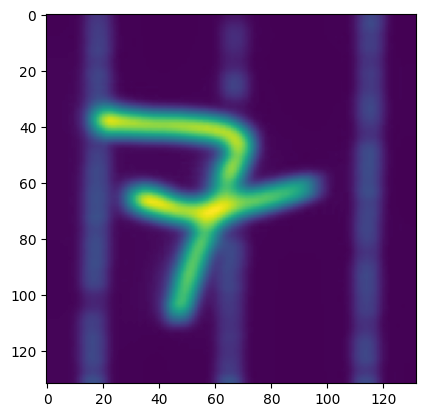

1/1 [==============================] - 0s 60ms/step


17it [00:06,  2.52it/s]

7


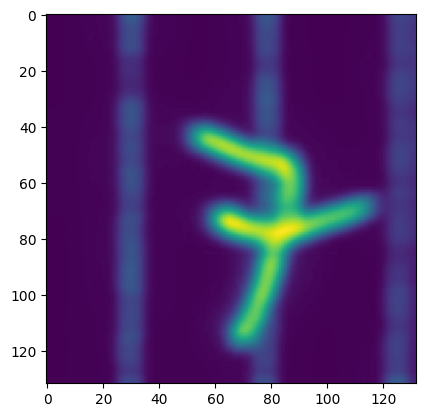

1/1 [==============================] - 0s 55ms/step


18it [00:07,  2.46it/s]

7


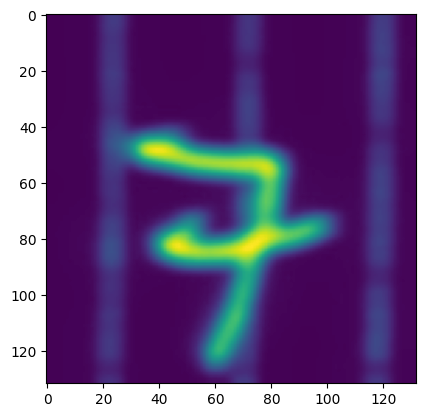

1/1 [==============================] - 0s 51ms/step


19it [00:07,  2.44it/s]

7


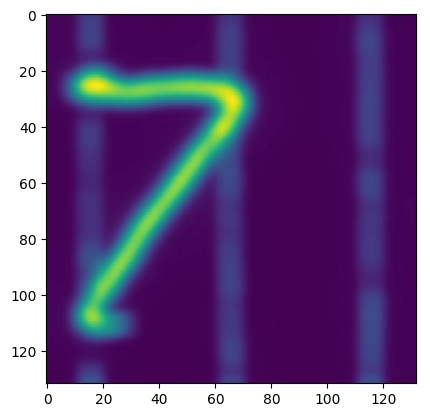

1/1 [==============================] - 0s 53ms/step


20it [00:08,  2.45it/s]

2


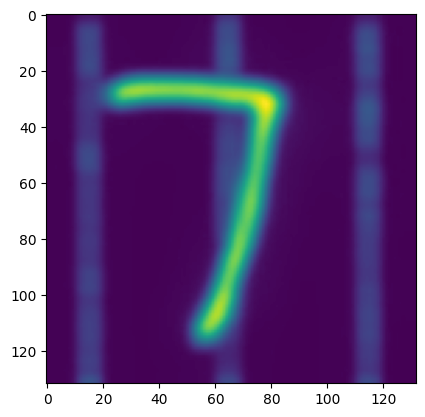

1/1 [==============================] - 0s 55ms/step


21it [00:08,  1.95it/s]

7


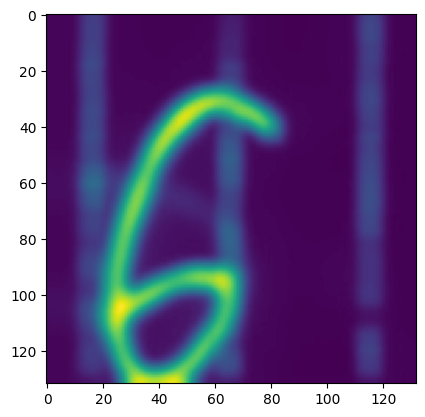

1/1 [==============================] - 0s 57ms/step


22it [00:09,  2.06it/s]

9


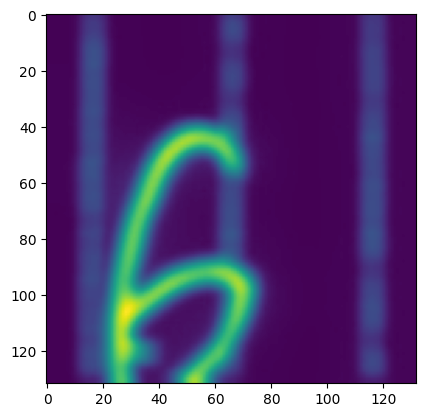

1/1 [==============================] - 0s 59ms/step


23it [00:09,  2.11it/s]

7


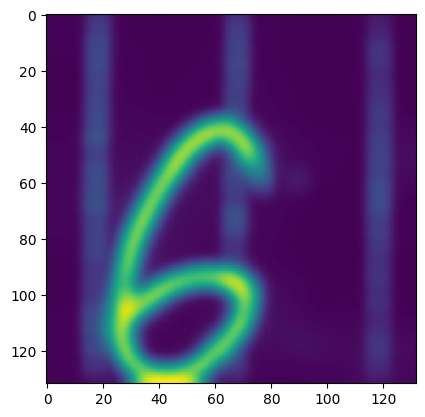

1/1 [==============================] - 0s 54ms/step


24it [00:10,  2.19it/s]

5


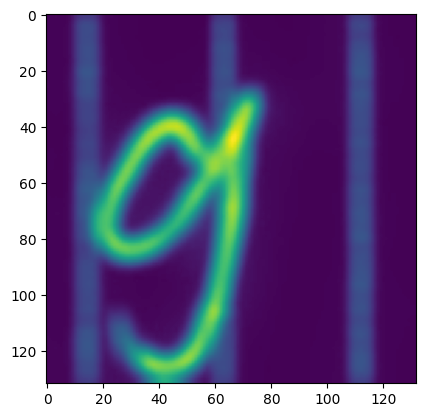

1/1 [==============================] - 0s 54ms/step


25it [00:10,  2.22it/s]

7


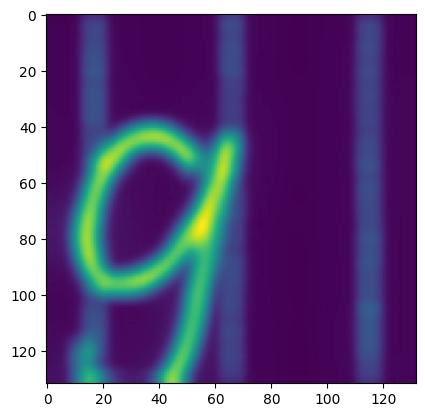

1/1 [==============================] - 0s 82ms/step


26it [00:10,  2.23it/s]

1


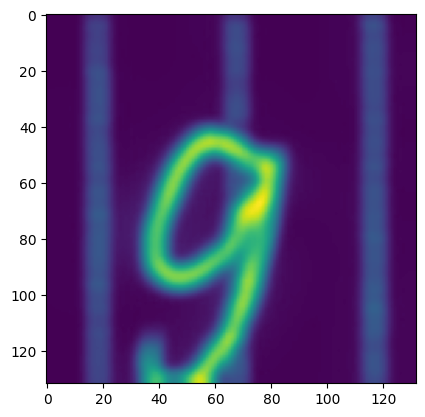

1/1 [==============================] - 0s 79ms/step


27it [00:11,  2.08it/s]

9


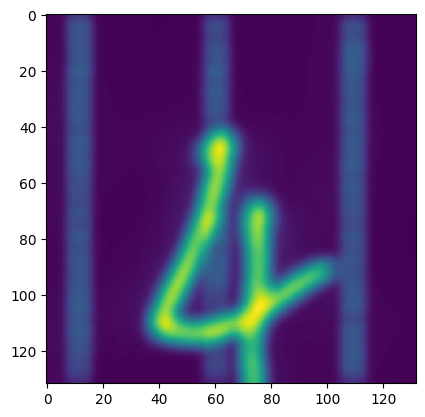

1/1 [==============================] - 0s 87ms/step


28it [00:12,  2.00it/s]

6


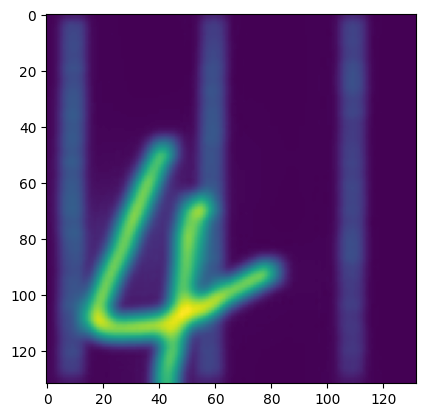

1/1 [==============================] - 0s 82ms/step


29it [00:12,  1.90it/s]

0


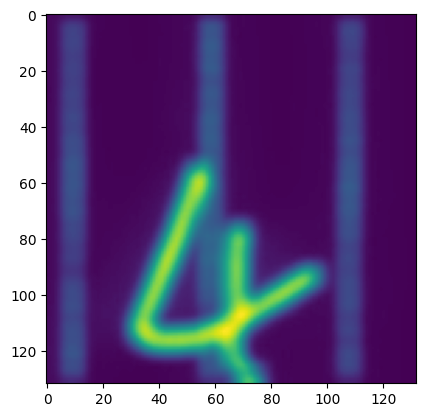

1/1 [==============================] - 0s 91ms/step


30it [00:13,  1.84it/s]

0


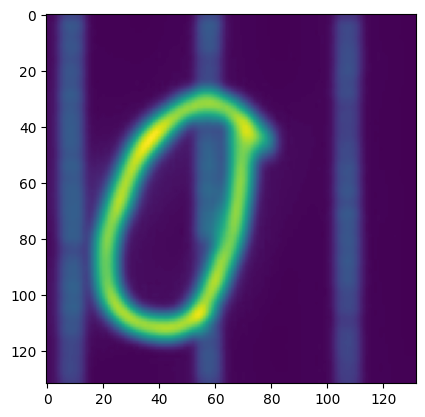

1/1 [==============================] - 0s 52ms/step


31it [00:13,  1.86it/s]

0


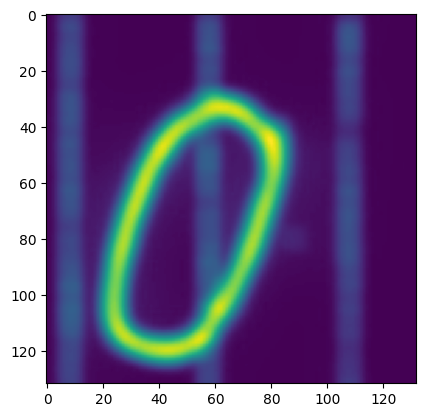

1/1 [==============================] - 0s 54ms/step


32it [00:14,  1.95it/s]

7


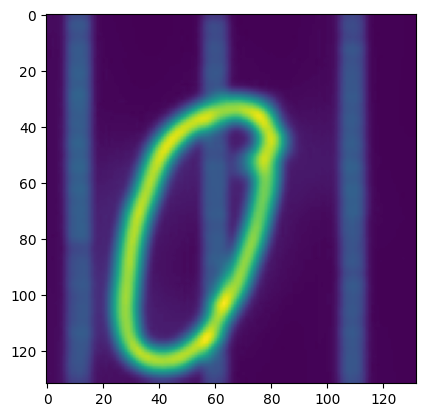

1/1 [==============================] - 0s 60ms/step


33it [00:14,  2.07it/s]

7


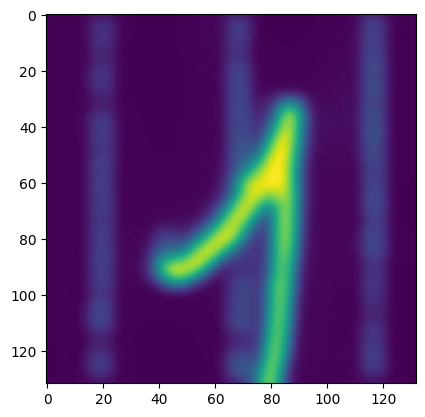

1/1 [==============================] - 0s 52ms/step


34it [00:15,  2.14it/s]

1


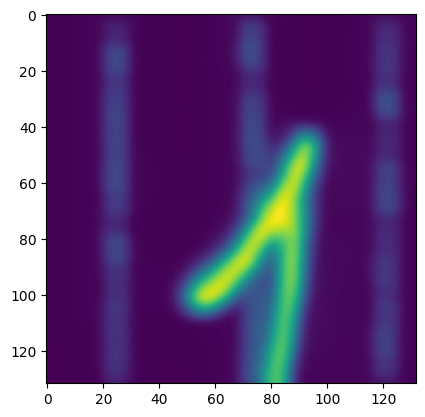

1/1 [==============================] - 0s 55ms/step


35it [00:15,  2.14it/s]

7


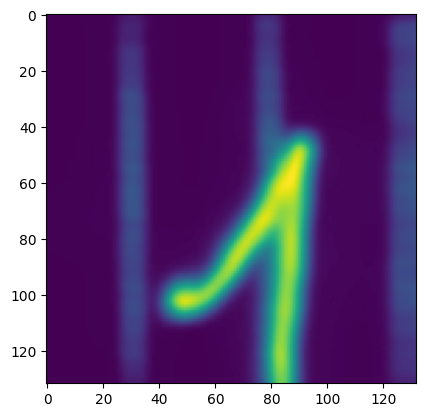

1/1 [==============================] - 0s 50ms/step


36it [00:15,  2.25it/s]

7
0.1388888888888889


In [43]:
# entry point, run the example
run_example()